In [1]:
# インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import statsmodels.api as sm
from decimal import Decimal, ROUND_HALF_UP
from sklearn.metrics import mean_squared_error
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [335]:
# シンプルデータセット1作成コード

np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]


In [336]:
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=0.7, random_state=50)
#print(X_train, X_test, y_train, y_test)

# SVMスクラッチ

分類のためのサポートベクターマシン（SVM、サポートベクトルマシン）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


SVMには学習時に分類の間違いを認めるソフトマージンSVMと、認めないハードマージンSVMがありますが、ここでは実装が単純なハードマージンSVMを扱います。


以下に雛形を用意してあります。このScratchSVMClassifierクラスにコードを書き加えていってください。



In [301]:
# 雛形
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter=50, lr=1e-5, kernel='linear', threshold=1e-5, verbose=False, gamma = 0.3):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.gamma = gamma
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # ラムダをランダムで生成
        np.random.seed(seed=0)
        self._lambda = np.random.rand(len(X), 1)
        for i in range(self.iter):
            self._lagrange_multiplier_for(X, y)
            # 検証データが変数に入れられていた場合、そっちも計算
            if (X_val is not None) and (y_val is not None):
                self.val_lambda = self._lagrange_multiplier_dot(X_val, y_val)
                if self.verbose == True:
                    print("iter : {} [val_lambda[0] : {}]".format(i, self.val_lambda[0]))
        
                
            # 学習過程の出力可否
            if self.verbose == True:
                print("iter : {} [train_lambda[0] : {}]".format(i, self._lambda[0]))        
                
        self.index_support_vectors = np.where(self._lambda > self.threshold)[0] # lambdaの中からthreshold以上のインデックスを取得
        self._identification_support_vector(self.index_support_vectors)
        #print("サポートベクターの数 : {}".format(len(self.index_support_vectors)))

    
    
    # カーネルトリック
    def _kernel_choice(self, Xi, Xj):
        if self.kernel == "linear": # 線形カーネルの場合
            K = np.dot(Xi, Xj.T)
            return K
        
        elif self.kernel == "poly": # 多項式カーネルの場合
            d = 3
            r = 0.8
            K = (self.gamma*(np.dot(Xi, Xj.T) + r))**d
            return K
        
        elif self.kernel == "gaussian": # ガウシアンカーネルの場合
            pass
        
        else:
            print("cannot found", self.kernel)
        
    
    # ラグランジュの未定乗数法でラムダを更新・出力する関数(for.ver)
    def _lagrange_multiplier_for(self, X, y):
        for i in range(X.shape[0]):
            par_diff = 0 #偏微分を初期化
            for j in range(X.shape[0]):
                par_diff += (self._lambda[j] * y[i] * y[j] * self._kernel_choice(X[i], X[j])) # 偏微分を計算
            self._lambda[i] += (self.lr * (1- par_diff))[0] # 学習率を掛けて加算
            
            if self._lambda[i] < 0: # ゼロ以下ならゼロにする
                self._lambda[i] = 0
    
    
    # ラグランジュの未定乗数法でラムダを更新・出力する関数(dot.ver)
    def _lagrange_multiplier_dot(self, X, y):
        if y.shape == y.size:
            y = y.reshape(-1, 1)
        self._lambda += lr * (1 - np.dot(out_lambda_dot.T, (np.dot(y, y.T) * self._kernel_choice(X, X)))).T
        self._lambda = np.where(self._lambda < 0, 0)

    
    # サポートベクターを識別する関数
    def _identification_support_vector(self, isv):
        self.lam_sv = self._lambda[isv] # threshold以上のやつだけ抽出
        self.n_support_vectors = len(isv) # サポートベクターの数
        self.X_sv = X[isv] # サポートベクターの特徴量
        self.y_sv = y[isv] # サポートベクターのラベル
        

    # yを推測する関数
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        fx = np.dot(self.lam_sv.T, (self.y_sv.reshape(-1, 1) * self._kernel_choice(X, self.X_sv).T))
        pred = np.sign(fx[0]) # 符号だけ取り出し
        pred = pred.astype(np.int) # intに変換
        
        return pred

        
    # デバッグなど、データ眺めるための表示関数
    def print_function(self, X):
        print("サポートベクターの数 : {}".format(self.n_support_vectors))
        #print("サポートベクターのlambda : {}".format(self.lam_sv))
        #print("サポートベクターの特徴量 : {}".format(self.X_sv))
        #print("サポートベクターのラベル : {}".format(self.y_sv))
        #tmp1 = np.dot(X, self.X_sv.T)
        #print("カーネル関数 : {}".format(tmp1))
        #tmp2 = self.y_sv.reshape(-1, 1) * tmp1.T
        #print("yの転置とカーネル関数のアダマール : {}".format(tmp2))
        #tmp3 = np.dot(self.lam_sv.T, tmp2)
        #print(tmp3)
        print(self.index_support_vectors)
        print(self.X_sv)
        print(np.where(self._lambda > self.threshold)[0])
        print(X[self.index_support_vectors])

# 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 
$λ$ を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

$$
λ^{new}_i =λ_i + α(1−\sum_{j=1}^n λ_jy_iy_jk(x_i,x_j))
$$

ここで 
$$
k(x_i,x_j)
$$ 
 はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。

$$
k(x_i,x_j)=x_i^Tx_j
$$

条件として、更新毎に $λ_i>=0$を満たす必要があります。満たさない場合は $λ_i=0$とします。

$i,j$ : サンプルのインデックス

$λ^{new}_i$: 更新後のi番目のサンプルのラグランジュ乗数

$λ_i$: 更新前のi番目のサンプルのラグランジュ乗数

$α$ : 学習率

$λ_j$ : j番目のサンプルのラグランジュ乗数

$y_i$ : i番目のサンプルのラベル

$y_j$ : j番目のサンプルのラベル

$x_i$ : i番目のサンプルの特徴量ベクトル

$x_j$ : j番目のサンプルの特徴量ベクトル


あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。



### <span style="color:#CC0000">カーネルトリックとラグランジュの未定乗数法でラムダを更新・出力する関数を実装</span>

```
def _kernel_choice(self, Xi, Xj):
def _lagrange_multiplier(self, X, y):
```

# 【問題2】サポートベクターの決定
計算したラグランジュ乗数 λが設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。


閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。



### <span style="color:#CC0000">サポートベクターを決定するための関数を実装</span>
```
def _identification_support_vector(self, isv):
```

# 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた 
$f(x)$ の符号が分類結果です。

$$
f(x)=\sum_{n=1}^N λ_ny_{sv_n}k(x,s_n)
$$

$x$ : 推定したいデータの特徴量ベクトル

$N$ : サポートベクターの数

$n$ : サポートベクターのインデックス


$λ_n$ :n番目のサポートベクターのラグランジュ乗数

$y_{sv_n}$ : n番目のサポートベクターのラベル

$k()$ : カーネル関数

$s_n$ : n番目のサポートベクターの特徴量

### <span style="color:#CC0000">predictを実装</span>
```
def predict(self, X):
```

# 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

### <span style="color:#CC0000">predictで推定する</span>

In [236]:
# スクラッチクラスのインスタンスを作成
tmp = ScratchSVMClassifier(num_iter=50, lr=1e-2, kernel='linear', threshold=1e-3, verbose=False)

In [237]:
%%timeit -r 1 -n 1
#学習
tmp.fit(X_train,y_train)

1min 20s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [238]:
# 推測
scratch_pred = tmp.predict(X_test)
scratch_pred

array([ 1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1,
        1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1, -1, -1,
       -1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,
        1,  1,  1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  1,  1,  1, -1,
       -1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1, -1,
        1,  1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,
        1, -1, -1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1, -1,
        1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1])

In [239]:
tmp.print_function(X_train)

サポートベクターの数 : 12
[ 28  32  51  66 108 124 172 206 217 241 326 333]
[[-0.99950867  2.50800932]
 [-1.50642737  2.11125339]
 [ 0.27578332  3.55367903]
 [ 2.57058557 -0.31821676]
 [-1.02691331  1.43290911]
 [ 0.52318607  3.80838207]
 [ 3.52040615  0.14722093]
 [-0.5017044   3.72754957]
 [ 2.10579726 -1.53724472]
 [ 0.31304912 -2.82240177]
 [ 0.67098941 -0.58384118]
 [ 2.00639182 -0.32030542]]
[ 28  32  51  66 108 124 172 206 217 241 326 333]
[[ 2.42340322  0.48692572]
 [ 0.31369184  1.90748822]
 [-0.97854994  0.34188908]
 [-1.76320579 -0.07237927]
 [ 1.28107479 -0.21320964]
 [ 0.67098941 -0.58384118]
 [ 1.10298263 -0.54852515]
 [ 0.9829958  -0.6091934 ]
 [ 0.14096048  1.74864676]
 [ 2.23162545  0.38441708]
 [-0.15353118  1.82412078]
 [-0.51274884  1.43945252]]


### <span style="color:#CC0000">scikit-learnでも推定する</span>

In [240]:
# scikit-learnのインスタンス作成 
clf = SVC(kernel='linear', random_state=None)

In [241]:
clf.fit(X_train,y_train)

SVC(kernel='linear')

In [242]:
pred_clf = clf.predict(X_test)
pred_clf

array([ 1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1,
        1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1, -1, -1,
       -1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,
        1,  1,  1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  1,  1,  1, -1,
       -1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1, -1,
        1,  1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,
        1, -1, -1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1, -1,
        1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1])

In [243]:
clf.support_vectors_

array([[ 0.67098941, -0.58384118],
       [ 0.31369184,  1.90748822],
       [-0.97854994,  0.34188908]])

In [244]:
# スクラッチとsklearnの結果の比較
comp = scratch_pred - pred_clf
comp = np.where(comp==0, "OK", "NG")
result = pd.DataFrame(data = [scratch_pred, pred_clf, comp], index=["scratch", "sklearn", "accuracy"]).T
check = result["accuracy"] == "NG"
print("スクラッチとsklearnで予測が違う行の数 : {}".format(check.sum()))

スクラッチとsklearnで予測が違う行の数 : 0


In [245]:
# 正解率とか出す関数
def index_out(y, pred, label,outlist={}):
    cm = confusion_matrix(y, pred)
    ac = metrics.accuracy_score(y, pred)
    pr = metrics.precision_score(y, pred)
    rc = metrics.recall_score(y, pred)
    f1 = metrics.f1_score(y, pred)

    print('confusion matrix =', cm)
    print('accuracy = ', ac)
    print('precision = ', pr)
    print('recall = ', rc)
    print('f1 score = ', f1)

    outlist[label] = [cm, ac, pr, rc, f1]
    return outlist

In [246]:
outlist = {}
index_out(y_test,scratch_pred,"scratch")


confusion matrix = [[71  0]
 [ 0 79]]
accuracy =  1.0
precision =  1.0
recall =  1.0
f1 score =  1.0


{'scratch': [array([[71,  0],
         [ 0, 79]]),
  1.0,
  1.0,
  1.0,
  1.0]}

In [247]:
outlist = index_out(y_test,pred_clf,"sklearn")

confusion matrix = [[71  0]
 [ 0 79]]
accuracy =  1.0
precision =  1.0
recall =  1.0
f1 score =  1.0


### <span style="color:#CC0000">比較してみる</span>

In [248]:
pd.DataFrame(outlist, index= ['confusion matrix','accuracy','precision','recall','f1 score'])

,scratch,sklearn
confusion matrix,"[[71, 0], [0, 79]]","[[71, 0], [0, 79]]"
accuracy,1,1
precision,1,1
recall,1,1
f1 score,1,1


どちらも完璧に推測できている。

# 【問題5】決定領域の可視化
決定領域を可視化してください。


以下の例のようにサポートベクターは異なる色で示してください。



In [260]:
# 可視化関数
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, scratch_flg='OFF', step=0.01, title='decision region on 3-nn', xlabel='xlabel', ylabel='ylabel', target_names=['-1', '1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスタンスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    if scratch_flg == "ON":
        index_num = model.index_support_vectors
        XX = X[index_num]
        plt.scatter(XX[:,0], XX[:,1], s=50, c='y', marker='o')
        
        #plt.scatter(model.X_sv[:,0], model.X_sv[:,1], s=50, c='y', marker='o')
        
    else:
        plt.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1], s=50, c='y', marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

### <span style="color:#CC0000">可視化関数でプロット</span>

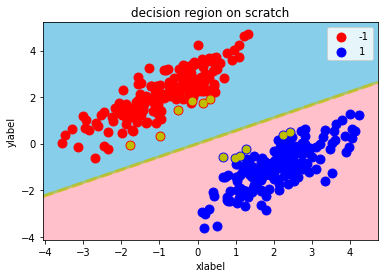

In [258]:
decision_region(X_train, y_train, tmp, "ON", step=0.01, title='decision region on scratch')

### <span style="color:#CC0000">scikit-learnも可視化してみる</span>

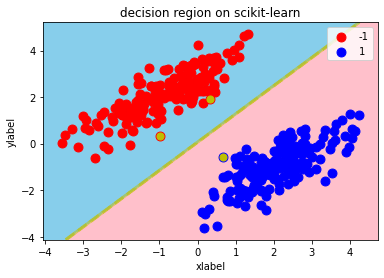

In [261]:
decision_region(X_train, y_train, clf,"OFF", step=0.01, title='decision region on scikit-learn')

精度がだいぶ違う。

# 【問題6】（アドバンス課題）多項式カーネル関数の作成
最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。


「線形カーネルの式」

$$
k(x_i,x_j)=x^T_ix_j
$$


「多項式カーネルの式」

$$
k(x_i,x_j)=(γx^T_ix_j+θ_0)^d
$$

$γ$,$θ_0$,$d$はハイパーパラメータです。


線形カーネルは 
$γ=1,θ_0=0, d=1$
の場合の多項式カーネルと等しいと言えます。

In [302]:
# スクラッチクラスのインスタンスを作成
tmp_poly = ScratchSVMClassifier(num_iter=100, lr=1e-4, kernel='poly', threshold=1e-5, verbose=False, gamma=0.7)

In [304]:
tmp_poly.fit(X_train,y_train)

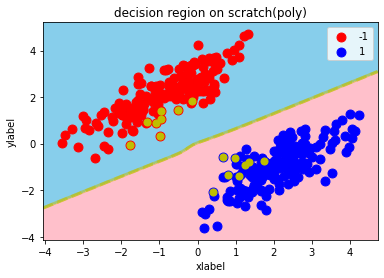

In [305]:
decision_region(X_train, y_train, tmp_poly, "ON", step=0.01, title='decision region on scratch(poly)')

In [306]:
poly = tmp_poly.predict(X_test)

In [307]:
hogehoge = y_test - poly
hogehoge = np.where(hogehoge == 0, "OK", "NG")

pd.DataFrame(data = [y_test, poly, hogehoge]).T

,0,1,2
0,1,1,OK
1,1,1,OK
2,-1,-1,OK
3,-1,-1,OK
4,-1,-1,OK
...,...,...,...
145,-1,-1,OK
146,-1,-1,OK
147,-1,-1,OK
148,1,1,OK


In [308]:
index_out(y_test,poly,"poly")

confusion matrix = [[71  0]
 [ 0 79]]
accuracy =  1.0
precision =  1.0
recall =  1.0
f1 score =  1.0


{'scratch': [array([[71,  0],
         [ 0, 79]]),
  1.0,
  1.0,
  1.0,
  1.0],
 'sklearn': [array([[71,  0],
         [ 0, 79]]),
  1.0,
  1.0,
  1.0,
  1.0],
 'poly': [array([[71,  0],
         [ 0, 79]]),
  1.0,
  1.0,
  1.0,
  1.0]}

In [326]:
pd.DataFrame(outlist)

,scratch,sklearn,poly
0,"[[71, 0], [0, 79]]","[[71, 0], [0, 79]]","[[71, 0], [0, 79]]"
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


<b>分類はちゃんとできている。</b>
